<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 15.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 264291598 bytes
User uploaded file "locations_categorical_features.csv" with length 27878177 bytes
User uploaded file "validation_data.csv" with length 8934313 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [3]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
563834,99996430_240804040_178195840,IP33 3UN,WEST SUFFOLK
563835,99996800_303056370_189735890,PO16 9PA,FAREHAM
563836,99998470_302856560_189531620,PO16 9UH,FAREHAM
563837,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH


In [4]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60000.000000,56187.500000,110333.333333,22666.666667,87666.666667,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0,66.666667,77.975528,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.666667,79000.000000,136000.000000,45000.000000,91000.000000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0,0.421053,0.632911,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.666667,64341.666667,154000.000000,42750.000000,111250.000000,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0,74.347333,98.937961,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.666667,101666.666667,215000.000000,62750.000000,152250.000000,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0,67.213115,67.213115,170000.0
4,1,F,S,6.0,55.701643,1.752959,14.0,11.9,11.0,136250.000000,168104.166667,252500.000000,60000.000000,192500.000000,18,4111570000,27468619000,16632627000,51.236727,-0.560636,655000.0,380.733945,289.639361,655000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144234,5,F,D,1.0,0.000000,0.000000,0.0,0.0,0.0,87250.000000,92500.000000,152500.000000,46750.000000,105750.000000,16,18126308000,28825475000,18214946000,50.896436,-2.576097,114000.0,30.659026,23.243243,570000.0
1144235,5,F,D,24.0,97.697793,1.639435,97.0,1.9,2.8,105000.000000,107500.000000,440000.000000,16000.000000,424000.000000,4,25424316000,711278000,10659618000,53.417210,-2.246727,178000.0,69.523810,65.581395,890000.0
1144236,5,F,S,6.0,193.121503,1.094252,26.0,8.7,8.3,89750.000000,92500.000000,163333.333333,45250.000000,118083.333333,9,8815989000,34831047000,24742056000,50.868112,0.567342,65600.0,-26.908078,-29.081081,328000.0
1144237,5,F,D,6.0,46.650826,2.156095,27.0,9.5,8.1,57750.000000,57750.000000,162500.000000,24666.666667,137833.333333,2,29718009000,3717254000,14712579000,53.731672,-2.624259,42800.0,-25.887446,-25.887446,214000.0


In [5]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,459500.000000,175000.000000,284500.000000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0,10.175439,-3.754789,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,187500.000000,80000.000000,107500.000000,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0,98.529412,88.811189,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,165833.333333,45000.000000,120833.333333,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0,29.380054,50.000000,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,219083.333333,240000.000000,360000.000000,131666.666667,228333.333333,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0,128.223659,108.333333,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,185000.000000,27400.000000,157600.000000,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0,23.809524,21.188580,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38522,5,F,D,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,167500.000000,20000.000000,147500.000000,26,22886393000,4770220000,7212565000,53.060015,-2.388207,78750.0,50.000000,42.319277,393750.0
38523,5,F,S,1.0,62.208157,4.362943,38.0,7.5,7.3,92333.333333,97000.000000,245000.000000,40625.000000,204375.000000,26,8821511000,25299709000,18394460000,52.085717,0.720703,186000.0,101.444043,91.752577,930000.0
38524,5,F,D,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,250000.000000,84000.000000,166000.000000,26,6938065000,27433863000,19483321000,51.800099,0.725616,112000.0,6.140178,5.000000,560000.0
38525,5,F,T,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,268000.000000,65000.000000,203000.000000,26,7548684000,32765304000,21992537000,50.834805,-0.137428,108400.0,-33.885642,-31.734453,542000.0


In [6]:
#remove outliers
#remove outliers (properties with bedrooms over 5, properties with prices under 10K and over 1M were removed before the train_test data was passed into the routine)
#df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1000000) ]
#df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1000000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]
#-------------------------------------------------------------------------------------------------------
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_3mnths'] <=100) ]
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_4mnths'] <=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_3mnths']<=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_4mnths'] <=100) ]

In [7]:
#remove columns: 'this_price_per_bedroom',	'compare_ppd_re_hist_median_3mnths',	'compare_ppd_re_hist_median_4mnths'
df_train_test_data=df_train_test_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)
df_validation_data=df_validation_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)

In [8]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [9]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [10]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [11]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [12]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
1116690,5,2,3,5.0,35.378280,0.836587,6.0,13.4,13.0,96250.000000,88000.000000,210000.000000,48889.500000,161110.500000,14,29013404000,6234863000,13052317000,53.371351,-3.174071,816000.0
109482,2,1,1,25.0,43.015525,1.341193,22.0,12.9,12.0,175000.000000,166666.666667,296666.666667,102500.000000,194166.666667,13,1392360900,24640152000,14725164000,51.623234,-0.264351,315000.0
254868,2,2,3,19.0,104.725313,1.501777,41.0,9.8,8.6,46000.000000,40833.333333,129000.000000,23333.333333,105666.666667,16,39291266000,17253977000,27742979000,54.961780,-1.457310,123000.0
893724,3,2,4,1.0,37.144610,1.356924,8.0,9.6,10.1,107500.000000,94750.000000,140000.000000,63333.333333,76666.666667,21,8940404000,17644731000,7103739000,52.041730,-1.147226,320000.0
281060,2,2,4,5.0,117.534291,0.609998,32.0,9.1,8.2,114750.000000,82333.333333,125000.000000,87666.666667,37333.333333,20,10518249000,33715153000,25364572000,51.379485,1.334813,310000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1025674,4,2,2,21.0,65.959869,1.498433,41.0,8.9,7.5,115833.333333,129000.000000,231000.000000,50000.000000,181000.000000,11,16750523000,22289961000,11997904000,51.487002,-2.587286,542500.0
918950,4,2,4,9.0,101.975694,0.505188,28.0,9.6,8.6,48000.000000,43333.333333,102000.000000,15533.333333,86466.666667,23,19251098000,7760620000,8226563000,53.110248,-1.262023,234000.0
968425,4,2,4,8.0,45.651617,3.244663,12.0,10.7,9.9,67191.666667,71666.666667,154000.000000,26666.666667,127333.333333,4,14379377000,11671324000,4851733000,52.629438,-1.230495,440000.0
1039476,4,2,2,12.0,81.885713,1.194602,57.0,2.3,4.3,108250.000000,115000.000000,205000.000000,81666.666667,123333.333333,14,5974646000,23925008000,12820410000,51.462831,-1.026747,270000.0


In [13]:
dataset = df_train_test_data.values
dataset

array([[5, '2', '3', ..., 53.371351000000004, -3.174071, 816000.0],
       [2, '1', '1', ..., 51.623234000000004, -0.264351, 315000.0],
       [2, '2', '3', ..., 54.961780000000005, -1.45731, 123000.0],
       ...,
       [4, '2', '4', ..., 52.629438, -1.2304950000000001, 440000.0],
       [4, '2', '2', ..., 51.462831, -1.0267469999999999, 270000.0],
       [3, '2', '2', ..., 52.48969399999999, -1.818236, 176000.0]],
      dtype=object)

In [14]:
X1 = dataset[:,0:20]
Y1 = dataset[:,20]
#all features

In [15]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [16]:
X_Validation=validation_dataset[:,0:20]
Y_Validation =validation_dataset[:,20]

In [17]:
from sklearn import preprocessing

In [18]:
min_max_scaler = preprocessing.MinMaxScaler()

In [19]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[1.        , 1.        , 0.66666667, ..., 0.34619299, 0.58365522,
        0.33903924],
       [0.25      , 0.        , 0.        , ..., 0.39079396, 0.28232977,
        0.72908564],
       [0.25      , 1.        , 0.66666667, ..., 0.73787121, 0.85779976,
        0.56917013],
       ...,
       [0.75      , 1.        , 1.        , ..., 0.12755137, 0.45577061,
        0.59957455],
       [0.75      , 1.        , 0.33333333, ..., 0.34000995, 0.25468088,
        0.62688686],
       [0.5       , 1.        , 0.33333333, ..., 0.01412527, 0.43168273,
        0.52078819]])

In [20]:

print(min(Y1))
print(max(Y1))

14500.0
999999.0


In [21]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [22]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
999000.0


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.3)

In [25]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(717847, 20) (307649, 20) (717847,) (307649,)


In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [27]:
model = Sequential([
    Dense(500, activation='relu', input_shape=X1_train.shape[1:]),
    Dense(1)
])

In [28]:
my_optimizer = keras.optimizers.Adam(learning_rate=0.009)
model.compile(
              loss='mean_squared_error',
               optimizer=my_optimizer)

In [29]:
import numpy as np

In [30]:
X1_train = np.asarray(X1_train).astype('float32')

In [31]:
Y1_train = np.asarray(Y1_train).astype('float32')

In [32]:
X1_test = np.asarray(X1_test).astype('float32')
Y1_test = np.asarray(Y1_test).astype('float32')

In [33]:
hist = model.fit(X1_train, Y1_train,
          epochs=100,
          validation_data=(X1_test, Y1_test))

Epoch 1/100
22433/22433 [==============================] - 49s 2ms/step - loss: 20285250715.2387 - val_loss: 5208846848.0000
Epoch 2/100
22433/22433 [==============================] - 36s 2ms/step - loss: 5009408535.8381 - val_loss: 4798744064.0000
Epoch 3/100
22433/22433 [==============================] - 36s 2ms/step - loss: 4757914627.6402 - val_loss: 4705434624.0000
Epoch 4/100
22433/22433 [==============================] - 35s 2ms/step - loss: 4673825361.6361 - val_loss: 4648392704.0000
Epoch 5/100
22433/22433 [==============================] - 36s 2ms/step - loss: 4658315863.3645 - val_loss: 4606643200.0000
Epoch 6/100
22433/22433 [==============================] - 36s 2ms/step - loss: 4611764731.8805 - val_loss: 4567748096.0000
Epoch 7/100
22433/22433 [==============================] - 35s 2ms/step - loss: 4564035481.7666 - val_loss: 4535124480.0000
Epoch 8/100
22433/22433 [==============================] - 35s 2ms/step - loss: 4523426317.9217 - val_loss: 4534120448.0000
Epoch 9

In [34]:
prediction1=model.predict(X1_test)
#print(prediction1)

In [36]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','max_ppb_3mnths_ago',	'min_ppb_3mnths_ago',	'spread_ppb_3mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,2.0,2.0,2.0,8.000000,95.728249,1.325848,26.000000,10.199999,9.300000,93743.750000,93743.750000,180000.000000,50000.000000,130000.000000,2.0,7.317999e+09,1.907784e+10,1.043666e+10,52.143997,-0.472293,205000.0,202202.390625,2797.609375,7.826618e+06,2797.609337,73179986_190778388_104366572
1,3.0,2.0,3.0,7.000000,94.446037,0.560378,18.000000,8.600000,7.100000,74250.000000,62500.003906,154500.000000,29000.000000,125500.000000,8.0,2.498272e+10,2.974089e+09,9.473678e+09,53.255672,-2.492443,160000.0,186910.109375,-26910.109375,7.241540e+08,26910.109327,249827185_29740892_94736783
2,4.0,2.0,4.0,3.000000,116.330078,0.415039,43.000000,7.000000,6.000000,82250.000000,82250.000000,140000.015625,35333.332031,104666.664062,1.0,1.042339e+10,3.530675e+10,2.619214e+10,51.093929,1.173209,340000.0,356480.031250,-16480.031250,2.715914e+08,16480.031068,104233943_353067540_261921423
3,3.0,2.0,4.0,5.000000,20.992041,4.299521,8.000000,10.500000,10.599999,84500.000000,95625.000000,129999.992188,50000.000000,80000.000000,23.0,1.083373e+10,2.212455e+10,1.078763e+10,51.516537,-1.733298,450000.0,344847.531250,105152.468750,1.105704e+10,105152.467437,108337326_221245501_107876301
4,2.0,1.0,2.0,10.999999,81.398506,0.580227,2.000000,7.000000,6.200000,42000.000000,46500.000000,109974.992188,21666.666016,88308.335938,16.0,2.768968e+10,3.281388e+09,1.212754e+10,53.447605,-2.743746,82000.0,77696.414062,4303.585938,1.852085e+07,4303.585947,276896809_32813878_121275382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307644,2.0,2.0,2.0,2.000000,79.972588,1.916276,22.000000,7.900000,8.000000,96666.671875,109166.664062,183333.328125,69250.000000,114083.335938,5.0,9.207295e+09,3.297875e+10,2.433751e+10,51.351665,1.134932,250000.0,223911.140625,26088.859375,6.806286e+08,26088.859845,92072950_329787453_243375084
307645,3.0,2.0,4.0,8.000000,27.286058,0.568367,10.000000,10.000000,9.700000,111000.000000,111000.000000,157500.000000,93333.335938,64166.664062,1.0,4.995057e+09,2.572871e+10,1.471611e+10,51.335869,-0.829426,410000.0,401588.781250,8411.218750,7.074860e+07,8411.218699,49950566_257287127_147161088
307646,2.0,2.0,2.0,4.000000,84.224335,0.797683,22.000000,10.300000,9.700000,85000.000000,86666.671875,195125.015625,41650.000000,153475.000000,20.0,2.369924e+10,2.424772e+09,8.955389e+09,53.274117,-2.136285,207500.0,167386.281250,40113.718750,1.609110e+09,40113.718352,236992389_24247721_89553889
307647,1.0,1.0,1.0,8.000000,73.694031,0.985443,27.000002,7.800000,7.300000,131250.000000,125833.335938,263333.312500,82500.007812,180833.328125,17.0,5.202075e+09,2.152354e+10,1.267463e+10,51.979424,-0.233974,128000.0,158576.671875,-30576.671875,9.349329e+08,30576.671892,52020746_215235359_126746276


In [37]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,2.0,2.0,2.0,8.000000,95.728249,1.325848,26.000000,10.199999,9.300000,93743.750000,93743.750000,180000.000000,50000.000000,130000.000000,2.0,7.317999e+09,1.907784e+10,1.043666e+10,52.143997,-0.472293,205000.0,202202.390625,2797.609375,7.826618e+06,2797.609337,73179986_190778388_104366572,NaN,NaN,NaN
1,3.0,2.0,3.0,7.000000,94.446037,0.560378,18.000000,8.600000,7.100000,74250.000000,62500.003906,154500.000000,29000.000000,125500.000000,8.0,2.498272e+10,2.974089e+09,9.473678e+09,53.255672,-2.492443,160000.0,186910.109375,-26910.109375,7.241540e+08,26910.109327,249827185_29740892_94736783,NaN,NaN,NaN
2,4.0,2.0,4.0,3.000000,116.330078,0.415039,43.000000,7.000000,6.000000,82250.000000,82250.000000,140000.015625,35333.332031,104666.664062,1.0,1.042339e+10,3.530675e+10,2.619214e+10,51.093929,1.173209,340000.0,356480.031250,-16480.031250,2.715914e+08,16480.031068,104233943_353067540_261921423,NaN,NaN,NaN
3,3.0,2.0,4.0,5.000000,20.992041,4.299521,8.000000,10.500000,10.599999,84500.000000,95625.000000,129999.992188,50000.000000,80000.000000,23.0,1.083373e+10,2.212455e+10,1.078763e+10,51.516537,-1.733298,450000.0,344847.531250,105152.468750,1.105704e+10,105152.467437,108337326_221245501_107876301,NaN,NaN,NaN
4,2.0,1.0,2.0,10.999999,81.398506,0.580227,2.000000,7.000000,6.200000,42000.000000,46500.000000,109974.992188,21666.666016,88308.335938,16.0,2.768968e+10,3.281388e+09,1.212754e+10,53.447605,-2.743746,82000.0,77696.414062,4303.585938,1.852085e+07,4303.585947,276896809_32813878_121275382,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307644,2.0,2.0,2.0,2.000000,79.972588,1.916276,22.000000,7.900000,8.000000,96666.671875,109166.664062,183333.328125,69250.000000,114083.335938,5.0,9.207295e+09,3.297875e+10,2.433751e+10,51.351665,1.134932,250000.0,223911.140625,26088.859375,6.806286e+08,26088.859845,92072950_329787453_243375084,NaN,NaN,NaN
307645,3.0,2.0,4.0,8.000000,27.286058,0.568367,10.000000,10.000000,9.700000,111000.000000,111000.000000,157500.000000,93333.335938,64166.664062,1.0,4.995057e+09,2.572871e+10,1.471611e+10,51.335869,-0.829426,410000.0,401588.781250,8411.218750,7.074860e+07,8411.218699,49950566_257287127_147161088,NaN,NaN,NaN
307646,2.0,2.0,2.0,4.000000,84.224335,0.797683,22.000000,10.300000,9.700000,85000.000000,86666.671875,195125.015625,41650.000000,153475.000000,20.0,2.369924e+10,2.424772e+09,8.955389e+09,53.274117,-2.136285,207500.0,167386.281250,40113.718750,1.609110e+09,40113.718352,236992389_24247721_89553889,NaN,NaN,NaN
307647,1.0,1.0,1.0,8.000000,73.694031,0.985443,27.000002,7.800000,7.300000,131250.000000,125833.335938,263333.312500,82500.007812,180833.328125,17.0,5.202075e+09,2.152354e+10,1.267463e+10,51.979424,-0.233974,128000.0,158576.671875,-30576.671875,9.349329e+08,30576.671892,52020746_215235359_126746276,NaN,NaN,NaN


In [38]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,2.0,2.0,2.0,8.000000,95.728249,1.325848,26.000000,10.199999,9.300000,93743.750000,93743.750000,180000.000000,50000.000000,130000.000000,2.0,7.317999e+09,1.907784e+10,1.043666e+10,52.143997,-0.472293,205000.0,202202.390625,2797.609375,7.826618e+06,2797.609337,73179986_190778388_104366572,NaN,NaN,NaN
1,3.0,2.0,3.0,7.000000,94.446037,0.560378,18.000000,8.600000,7.100000,74250.000000,62500.003906,154500.000000,29000.000000,125500.000000,8.0,2.498272e+10,2.974089e+09,9.473678e+09,53.255672,-2.492443,160000.0,186910.109375,-26910.109375,7.241540e+08,26910.109327,249827185_29740892_94736783,NaN,NaN,NaN
2,4.0,2.0,4.0,3.000000,116.330078,0.415039,43.000000,7.000000,6.000000,82250.000000,82250.000000,140000.015625,35333.332031,104666.664062,1.0,1.042339e+10,3.530675e+10,2.619214e+10,51.093929,1.173209,340000.0,356480.031250,-16480.031250,2.715914e+08,16480.031068,104233943_353067540_261921423,NaN,NaN,NaN
3,3.0,2.0,4.0,5.000000,20.992041,4.299521,8.000000,10.500000,10.599999,84500.000000,95625.000000,129999.992188,50000.000000,80000.000000,23.0,1.083373e+10,2.212455e+10,1.078763e+10,51.516537,-1.733298,450000.0,344847.531250,105152.468750,1.105704e+10,105152.467437,108337326_221245501_107876301,NaN,NaN,NaN
4,2.0,1.0,2.0,10.999999,81.398506,0.580227,2.000000,7.000000,6.200000,42000.000000,46500.000000,109974.992188,21666.666016,88308.335938,16.0,2.768968e+10,3.281388e+09,1.212754e+10,53.447605,-2.743746,82000.0,77696.414062,4303.585938,1.852085e+07,4303.585947,276896809_32813878_121275382,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307644,2.0,2.0,2.0,2.000000,79.972588,1.916276,22.000000,7.900000,8.000000,96666.671875,109166.664062,183333.328125,69250.000000,114083.335938,5.0,9.207295e+09,3.297875e+10,2.433751e+10,51.351665,1.134932,250000.0,223911.140625,26088.859375,6.806286e+08,26088.859845,92072950_329787453_243375084,NaN,NaN,NaN
307645,3.0,2.0,4.0,8.000000,27.286058,0.568367,10.000000,10.000000,9.700000,111000.000000,111000.000000,157500.000000,93333.335938,64166.664062,1.0,4.995057e+09,2.572871e+10,1.471611e+10,51.335869,-0.829426,410000.0,401588.781250,8411.218750,7.074860e+07,8411.218699,49950566_257287127_147161088,NaN,NaN,NaN
307646,2.0,2.0,2.0,4.000000,84.224335,0.797683,22.000000,10.300000,9.700000,85000.000000,86666.671875,195125.015625,41650.000000,153475.000000,20.0,2.369924e+10,2.424772e+09,8.955389e+09,53.274117,-2.136285,207500.0,167386.281250,40113.718750,1.609110e+09,40113.718352,236992389_24247721_89553889,NaN,NaN,NaN
307647,1.0,1.0,1.0,8.000000,73.694031,0.985443,27.000002,7.800000,7.300000,131250.000000,125833.335938,263333.312500,82500.007812,180833.328125,17.0,5.202075e+09,2.152354e+10,1.267463e+10,51.979424,-0.233974,128000.0,158576.671875,-30576.671875,9.349329e+08,30576.671892,52020746_215235359_126746276,NaN,NaN,NaN


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

In [39]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

65233.27225256846

In [40]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :37.77259149225254 %
Predictions where error is 15% or less :53.27889900503496 %
Predictions where error is 20% or less :65.80388689708076 %
Predictions where error is 50% or more :5.363904969624475 %


In [41]:
prediction_validation=model.predict(X_Validation_scale)

In [43]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','max_ppb_3mnths_ago',	'min_ppb_3mnths_ago',	'spread_ppb_3mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,459500.000000,175000.000000,284500.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,455931.750000,141932,2.01446e+10,141932,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,187500.000000,80000.000000,107500.000000,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,248294.421875,23294.4,5.4263e+08,23294.4,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,165833.333333,45000.000000,120833.333333,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,123205.351562,3205.35,1.02743e+07,3205.35,103333010_303705230_190276950
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,185000.000000,27400.000000,157600.000000,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,42747.722656,-9252.28,8.56046e+07,9252.28,324079420_66042660_170299350
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,125333.333333,33333.333333,92000.000000,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,146745.781250,13745.8,1.88947e+08,13745.8,274203190_292558650_213750350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,163333.333333,56000.000000,107333.333333,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,399634.187500,82634.2,6.82841e+09,82634.2,148740500_304966640_192878440
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,167500.000000,20000.000000,147500.000000,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,401335.625000,7585.62,5.75417e+07,7585.62,228863930_47702200_72125650
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,250000.000000,84000.000000,166000.000000,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,577856.625000,17856.6,3.18859e+08,17856.6,69380650_274338630_194833210
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,268000.000000,65000.000000,203000.000000,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,574630.687500,32630.7,1.06476e+09,32630.7,75486840_327653040_219925370


In [44]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,459500.000000,175000.000000,284500.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,455931.750000,141932,2.01446e+10,141932,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,187500.000000,80000.000000,107500.000000,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,248294.421875,23294.4,5.4263e+08,23294.4,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,165833.333333,45000.000000,120833.333333,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,123205.351562,3205.35,1.02743e+07,3205.35,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,185000.000000,27400.000000,157600.000000,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,42747.722656,-9252.28,8.56046e+07,9252.28,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,125333.333333,33333.333333,92000.000000,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,146745.781250,13745.8,1.88947e+08,13745.8,274203190_292558650_213750350,EX31 1NY,NORTH DEVON,EX31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,163333.333333,56000.000000,107333.333333,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,399634.187500,82634.2,6.82841e+09,82634.2,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,167500.000000,20000.000000,147500.000000,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,401335.625000,7585.62,5.75417e+07,7585.62,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,250000.000000,84000.000000,166000.000000,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,577856.625000,17856.6,3.18859e+08,17856.6,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,268000.000000,65000.000000,203000.000000,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,574630.687500,32630.7,1.06476e+09,32630.7,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [45]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [46]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

65625.68234806707

In [47]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :37.43958573072497 %
Predictions where error is 15% or less :52.71001150747986 %
Predictions where error is 20% or less :65.00287686996548 %
Predictions where error is 50% or more :5.6616800920598385 %


In [48]:
import matplotlib.pyplot as plt

In [49]:
import numpy as np

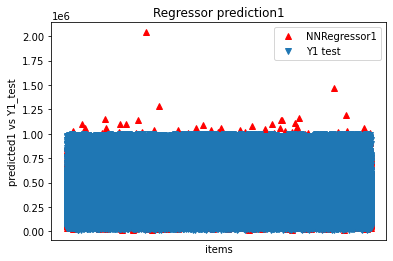

In [50]:
plt.figure()
plt.plot(prediction1, 'r^', label='NNRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

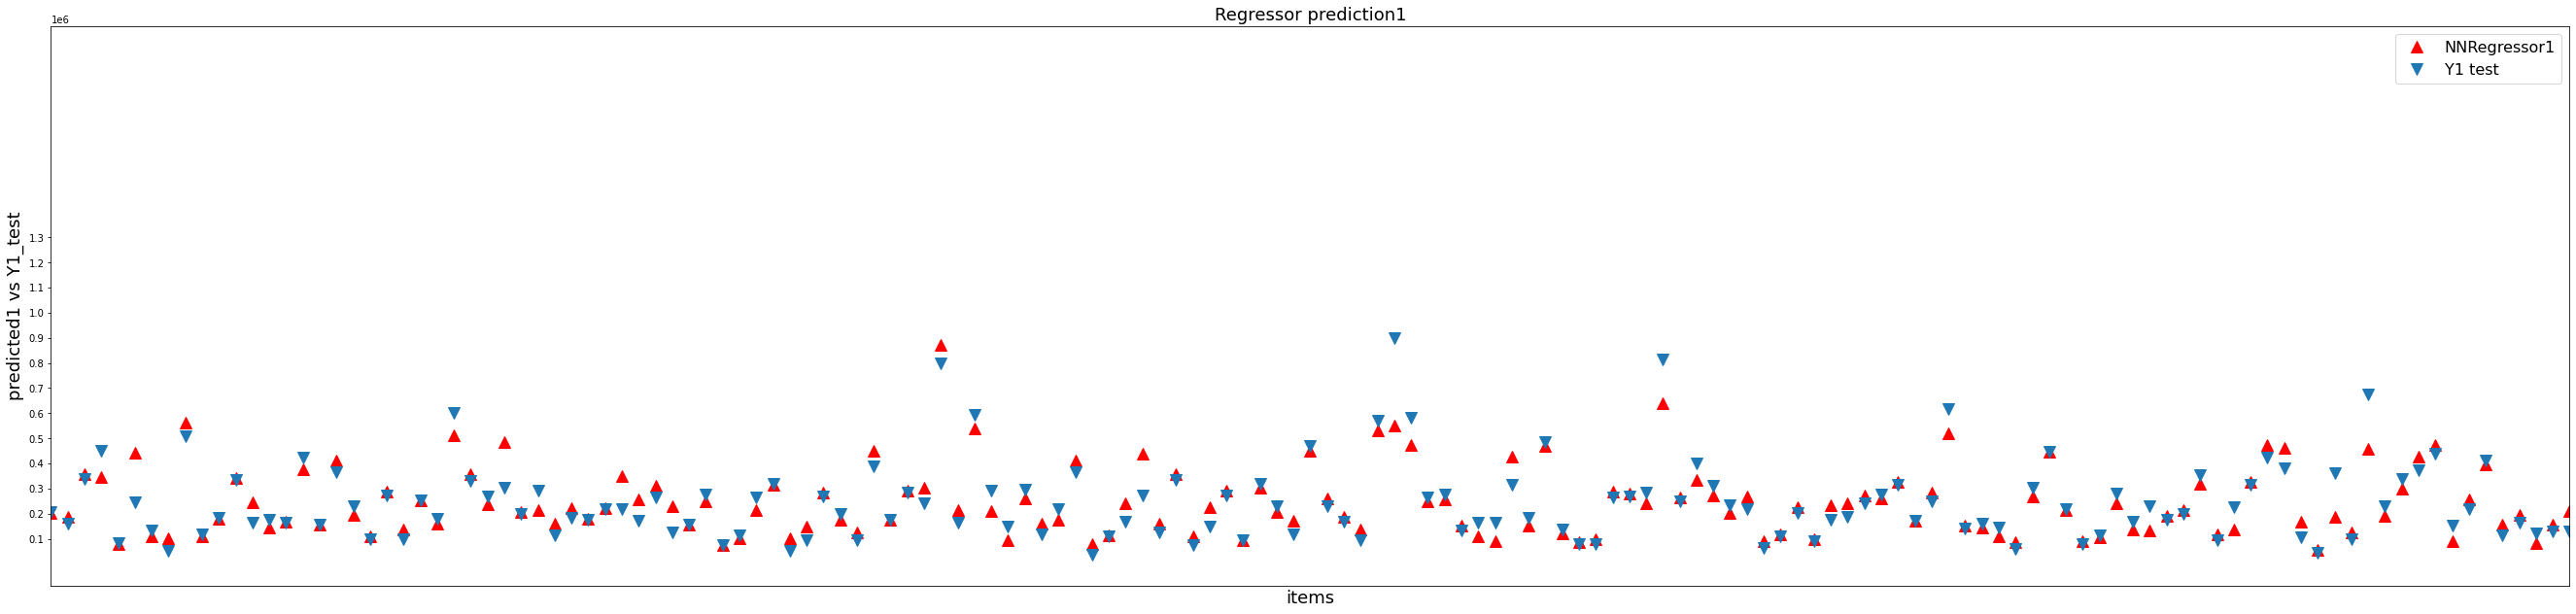

In [51]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='NNRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [52]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [53]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

65233.27151078658

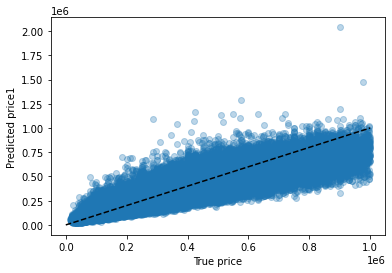

In [54]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [55]:
#test data has several very bad predictions:
#test prediction_90pc_df1
prediction_over90pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=90) ] 
within_90pc_error1=100*prediction_over90pc_df1.shape[0]/prediction_df1.shape[0]
print('Test predictions where error is 90% or more :' + str(within_90pc_error1) + ' %')

Test predictions where error is 90% or more :1.2605274192342573 %


In [56]:
prediction_over90pc_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,error_perc
7,3.0,2.0,2.0,13.999999,98.979607,0.392598,86.000000,3.200000,2.300000,44000.000000,45000.000000,97333.328125,20166.666016,77166.671875,15.0,2.774647e+10,2.317971e+09,1.249594e+10,53.525562,-2.593678,52000.0,101450.164062,-49450.164062,2.445319e+09,49450.163357,277464740_23179712_124959375,95.096468
44,3.0,2.0,3.0,7.000000,202.784866,0.283385,89.000000,0.300000,0.400000,31500.001953,36041.667969,80000.000000,15000.000000,65000.000000,10.0,3.462348e+10,1.411917e+10,2.378511e+10,54.571484,-1.143380,52500.0,100681.453125,-48181.453125,2.321453e+09,48181.454357,346234798_141191700_237851136,91.774199
62,2.0,2.0,1.0,11.999999,74.658119,0.499872,28.000000,9.799999,8.300000,50729.164062,48666.667969,200000.000000,22333.332031,177666.671875,5.0,3.876743e+10,1.632777e+10,2.693947e+10,54.895939,-1.579423,38550.0,78601.421875,-40051.421875,1.604116e+09,40051.421348,387674276_163277711_269394678,103.894738
197,4.0,2.0,2.0,10.999999,63.402645,1.102258,22.000000,10.000000,9.400000,59333.332031,62500.003906,82499.992188,24983.333984,57516.664062,8.0,2.707727e+10,1.474666e+09,1.199984e+10,53.505047,-2.470512,90000.0,191177.281250,-101177.281250,1.023684e+10,101177.279979,270772716_14746661_119998403,112.419200
340,3.0,2.0,3.0,21.999998,78.409447,1.440157,56.000000,8.900000,6.700000,65687.500000,65687.500000,138333.343750,30000.000000,108333.335938,1.0,2.522234e+10,1.008461e+09,1.038664e+10,53.390511,-2.257805,90000.0,182040.078125,-92040.078125,8.471376e+09,92040.077531,252223386_10084610_103866409,102.266753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307202,2.0,2.0,2.0,5.000000,162.836716,1.078724,47.000000,9.700000,8.900000,42000.000000,42000.000000,129999.992188,11750.000000,118250.000000,3.0,3.600237e+10,1.499038e+10,2.494739e+10,54.688126,-1.227456,31250.0,68250.125000,-37000.125000,1.369009e+09,37000.125405,360023654_149903770_249473884,118.400401
307397,3.0,1.0,1.0,32.000000,74.577286,0.852220,35.000000,10.699999,9.599999,158166.671875,175000.000000,313750.000000,100000.007812,213750.000000,13.0,1.551432e+09,2.756523e+10,1.757997e+10,51.407146,-0.022544,200000.0,399752.968750,-199752.968750,3.990125e+10,199752.971282,15514321_275652321_175799726,99.876486
307530,2.0,2.0,2.0,22.999998,69.585533,0.752809,22.000000,11.999999,11.099999,123333.343750,126423.335938,177500.000000,105000.007812,72500.000000,13.0,1.671769e+10,2.252619e+10,1.220515e+10,51.465271,-2.581117,125000.0,286392.218750,-161392.218750,2.604745e+10,161392.221275,167176909_225261937_122051533,129.113777
307563,2.0,1.0,1.0,1.000000,79.085197,0.727654,15.000001,9.299999,9.799999,88750.000000,110000.000000,148750.000000,53500.000000,95250.000000,10.0,1.913762e+10,2.736758e+10,1.715828e+10,51.044182,-2.815023,85000.0,167703.515625,-82703.515625,6.839871e+09,82703.515572,191376220_273675776_171582812,97.298254


In [57]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

65625.68234806757

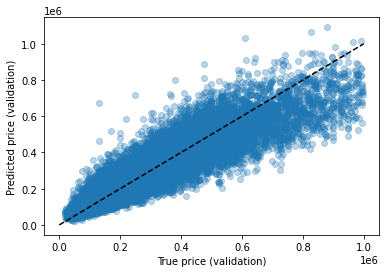

In [58]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()

In [59]:
#validation data has several very bad predictions:
#validation prediction_90pc_df1
prediction_over90pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=90) ] 
within_90pc_error1_val=100*prediction_over90pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 90% or more :' + str(within_90pc_error1_val) + ' %')

Predictions where error is 90% or more :1.3118527042577675 %


In [60]:
prediction_over90pc_df1_val

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,error_perc
16,1.0,1.0,1.0,18.0,88.726289,0.888273,12.0,11.8,11.2,88750.000000,75187.500000,205666.666667,40000.000000,165666.666667,26.0,3.982967e+10,1.783974e+10,2.833047e+10,55.013802,-1.439469,49500,118615.273438,69115.3,4.77692e+09,69115.3,398296690_178397430_283304660,139.627
48,1.0,1.0,1.0,53.0,104.698370,0.644203,53.0,11.7,8.6,710000.000000,254166.666667,710000.000000,710000.000000,0.000000,26.0,2.689830e+08,2.583653e+10,1.580284e+10,51.519313,-0.205359,367500,713808.500000,346308,1.1993e+11,346308,2689830_258365270_158028430,94.2336
66,1.0,1.0,1.0,4.0,55.348145,1.221984,15.0,11.6,9.9,108250.000000,139375.000000,331666.666667,74666.666667,257000.000000,26.0,1.456350e+10,2.377370e+10,1.287144e+10,51.343100,-2.250522,74000,145760.875000,71760.9,5.14962e+09,71760.9,145634970_237736980_128714370,96.9742
156,1.0,1.0,1.0,4.0,55.348145,1.221984,15.0,11.6,9.9,108250.000000,139375.000000,331666.666667,74666.666667,257000.000000,26.0,1.456350e+10,2.377370e+10,1.287144e+10,51.343100,-2.250522,75000,145760.875000,70760.9,5.0071e+09,70760.9,145634970_237736980_128714370,94.3478
159,1.0,1.0,1.0,6.0,75.156867,0.453190,23.0,9.9,8.3,122000.000000,108750.000000,173750.000000,35250.000000,138500.000000,26.0,6.681220e+09,1.934935e+10,9.718739e+09,52.018293,-0.693980,58500,141366.890625,82866.9,6.86692e+09,82866.9,66812200_193493480_97187390,141.653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34664,5.0,2.0,4.0,23.0,106.495958,0.424742,72.0,8.2,7.6,57333.333333,55833.333333,114000.000000,26499.666667,87500.333333,26.0,2.850524e+10,5.328915e+09,1.262060e+10,53.386753,-3.039939,162000,352863.687500,190864,3.64289e+10,190864,285052449_53289150_126205970,117.817
34713,5.0,2.0,2.0,14.0,98.318898,1.489947,60.0,11.8,9.5,41166.666667,39000.000000,102500.000000,10333.333333,92166.666667,26.0,3.473978e+10,1.344772e+10,2.343772e+10,54.559854,-1.320500,89000,184027.656250,95027.7,9.03026e+09,95027.7,347397750_134477230_234377160,106.773
34730,5.0,1.0,2.0,10.0,56.960515,1.130315,33.0,8.4,6.8,50500.000000,58325.000000,128333.333333,20500.000000,107833.333333,26.0,2.939118e+10,3.483122e+09,1.483113e+10,53.779837,-2.410257,113500,234887.234375,121387,1.47349e+10,121387,293911850_34831220_148311340,106.949
34743,5.0,2.0,4.0,9.0,63.496471,2.380537,21.0,10.1,9.0,49125.000000,55000.000000,167475.000000,32000.000000,135475.000000,26.0,3.268831e+10,6.852067e+09,1.732730e+10,53.883061,-3.039913,160000,370175.343750,210175,4.41737e+10,210175,326883130_68520670_173273010,131.36
